In [95]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import time
import matplotlib.pyplot as pl
import numpy as np
import itertools as it
from astropy.io import fits
import healpy as hp
from scipy import linalg

from src.core import PowSpecEstimator as PSE
from src import this_project as P

In [97]:
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
LMAX = NSIDE
BEAMSIZE = 0.5

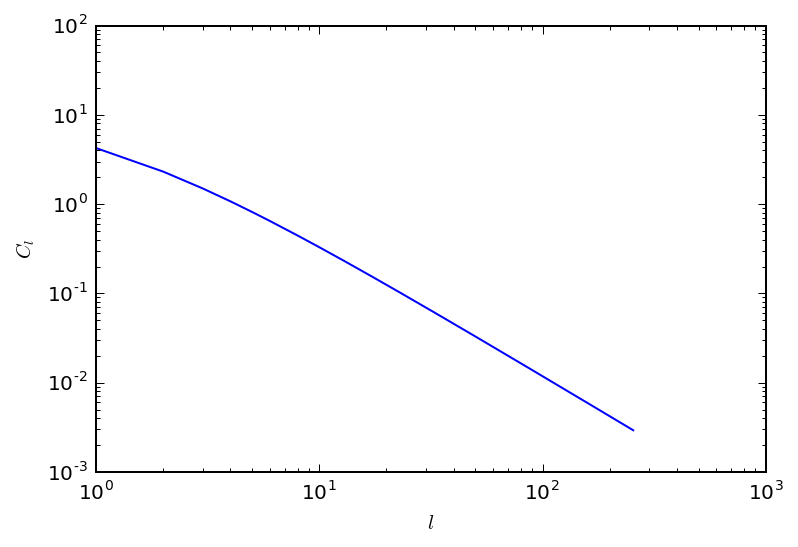

In [98]:
power = (lambda k: 12 / (k + 1) ** 1.5)
cl_in = power(np.arange(LMAX))
ls = np.arange(cl_in.size)
pl.loglog(cl_in)
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


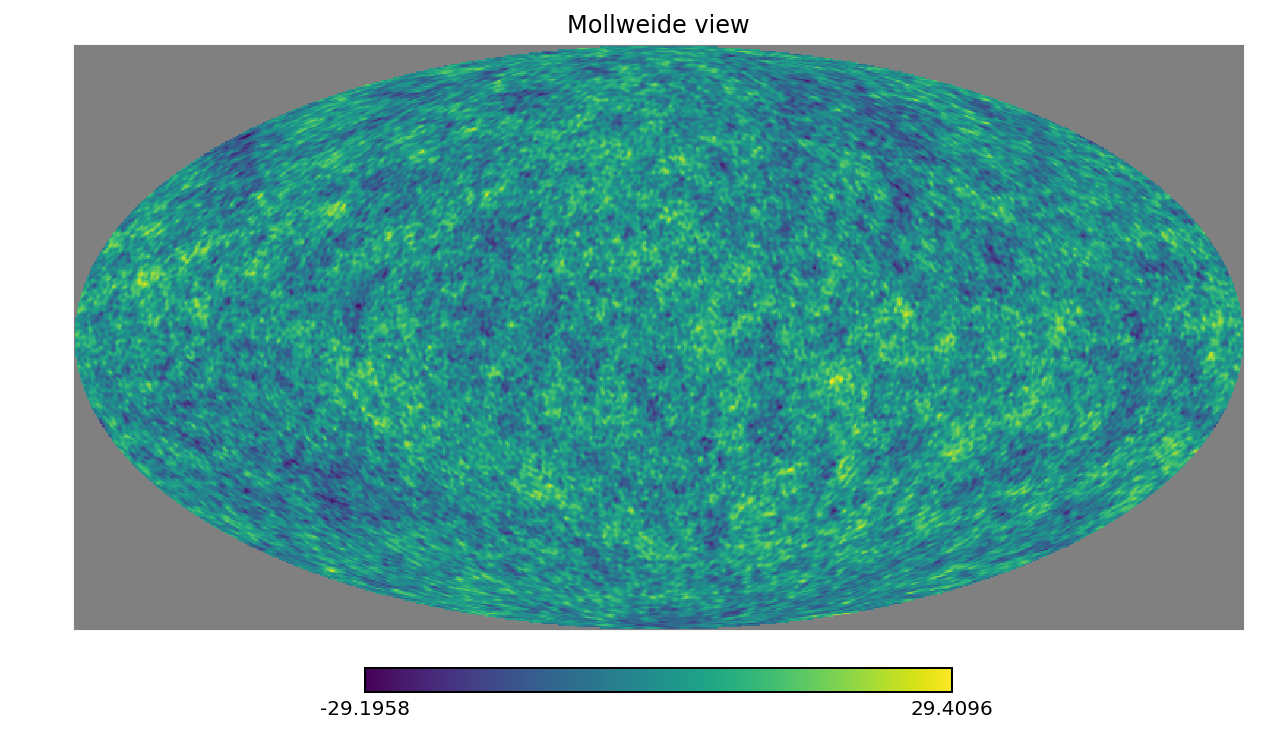

In [99]:
# generate field
random_field = hp.synfast(cl_in, NSIDE, verbose=False)

# simulate beam
random_field = hp.smoothing(random_field, fwhm=np.deg2rad(BEAMSIZE), iter=1)

# view field
hp.mollview(random_field, cmap=P.CMAP)

In [100]:
full_mask = fits.getdata('/Users/dlenz/projects/planck/mask_galplane_2048.hpx.fits')
mask = hp.ud_grade(full_mask['GAL060'].astype(np.float32), NSIDE, order_in='nest', order_out='ring')
mask = hp.smoothing(mask, fwhm=np.deg2rad(0.5), iter=1, verbose=False)

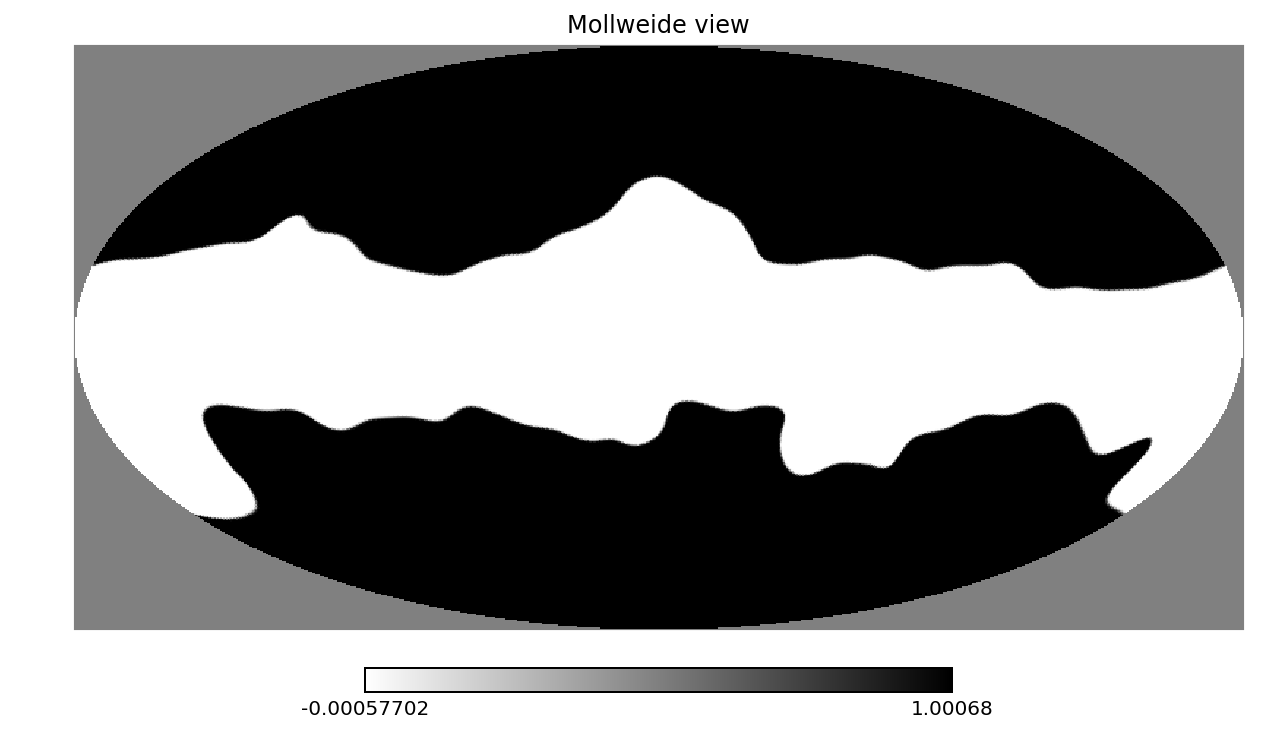

In [101]:
hp.mollview(mask, cmap=P.CMAP_GREY)

In [102]:
pse = PSE(random_field, mask=mask, lmax=LMAX, beam=BEAMSIZE)
pse.set_bins(nbins=25)

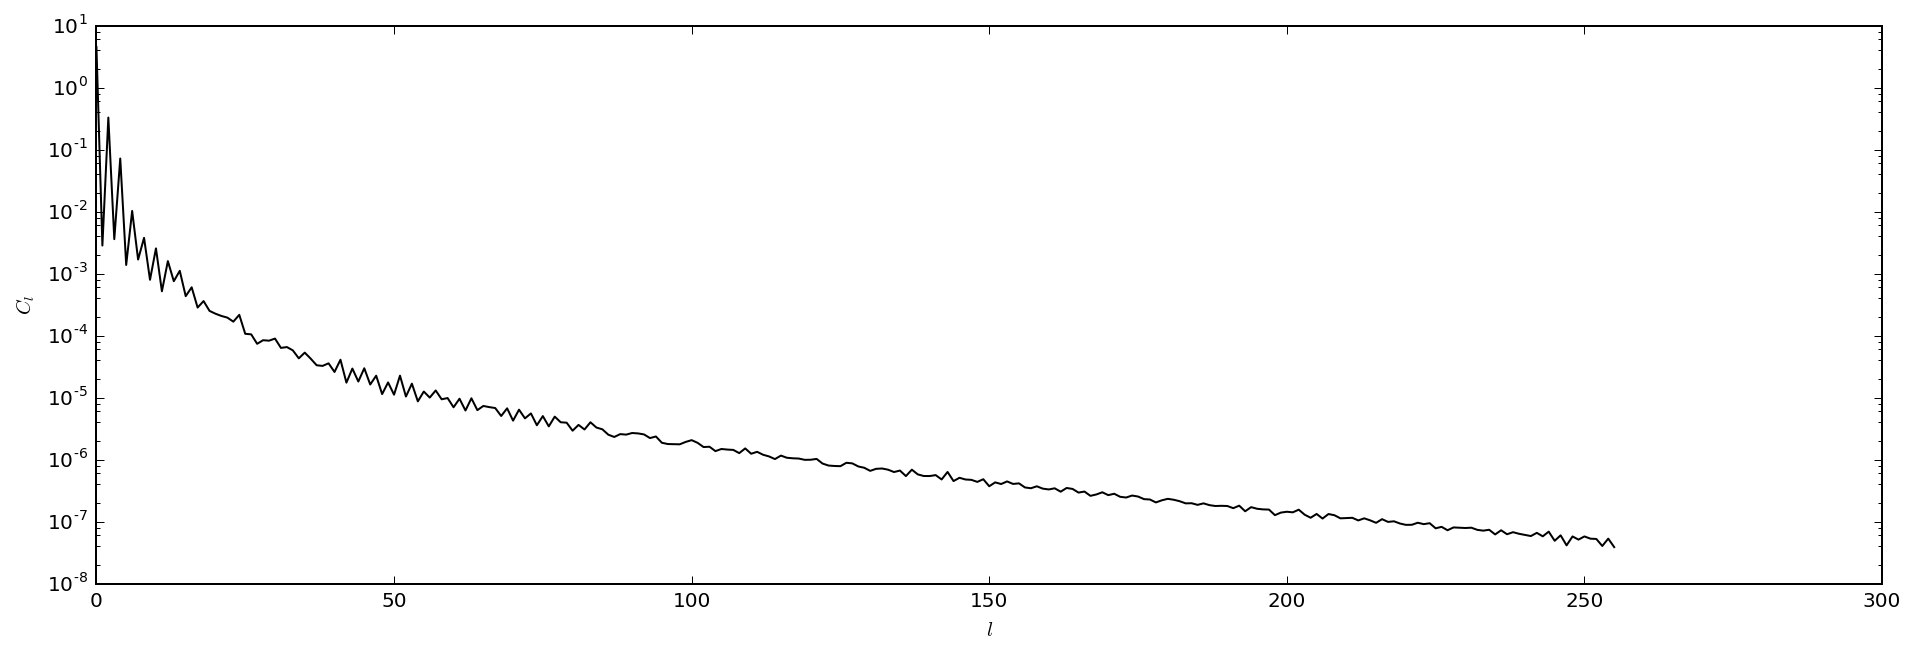

In [114]:
pl.figure(figsize=(16, 5))
pl.plot(pse.cl_mask, c='k')
pl.yscale('log')
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

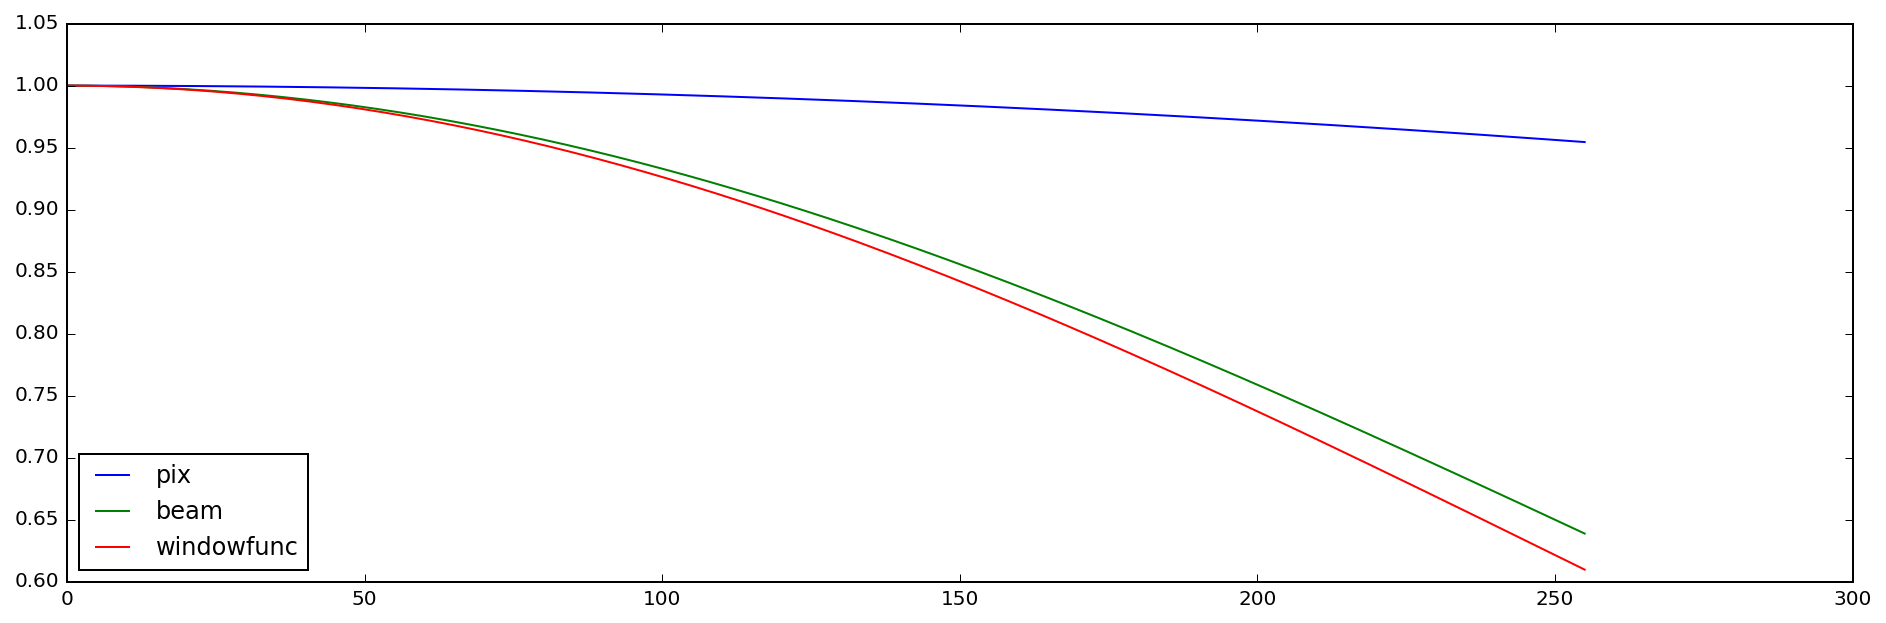

In [113]:
pl.figure(figsize=(16, 5))
pl.plot(pse.pixfunc, label='pix')
pl.plot(pse.beamfunc, label='beam')
pl.plot(pse.windowfunc, label='windowfunc')
pl.legend(loc='lower left')

(1.0, 100.0)

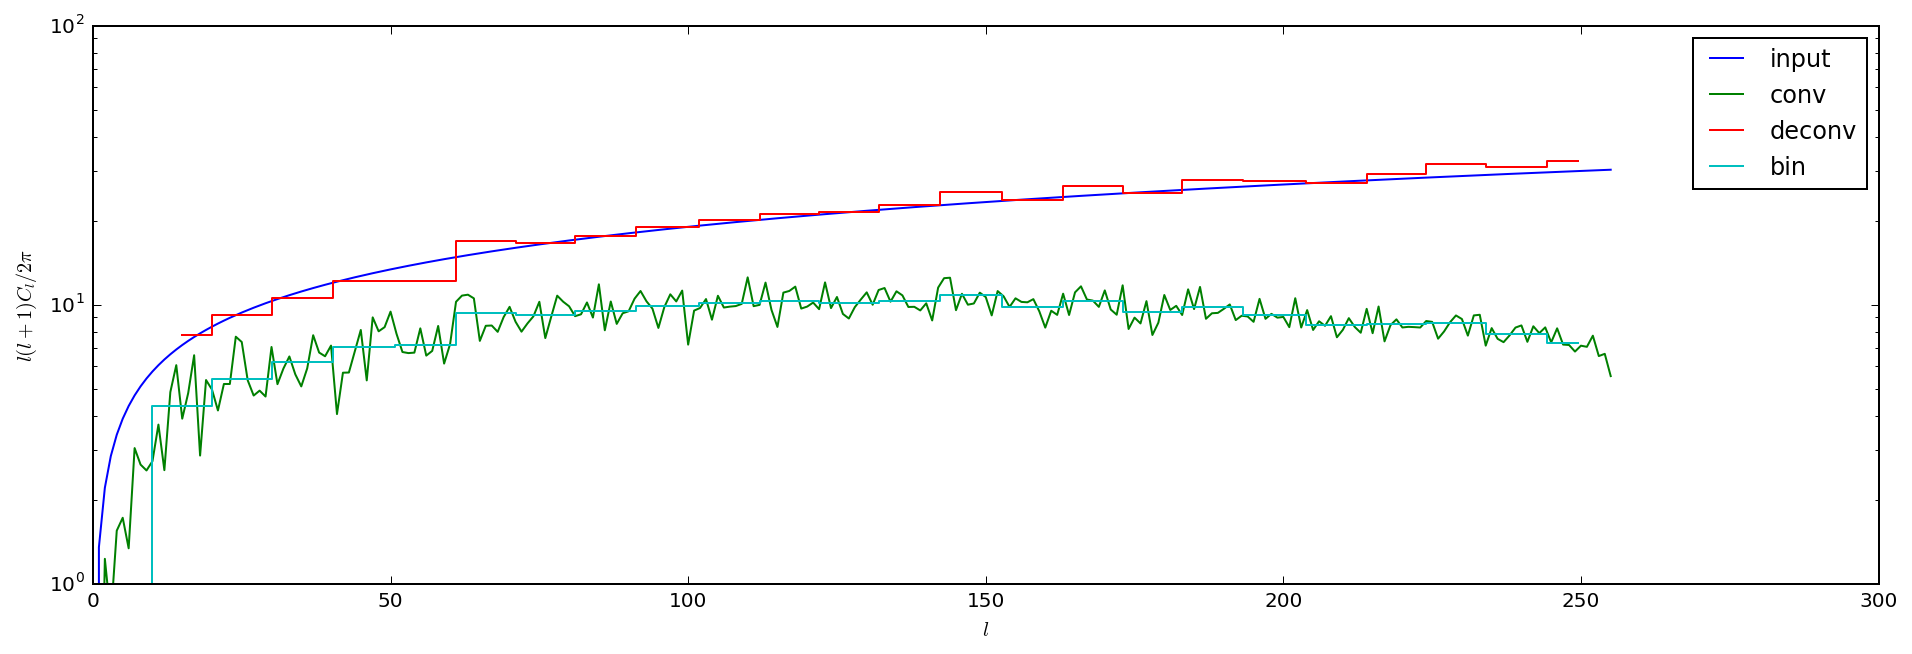

In [112]:
pl.figure(figsize=(16, 5))
pl.plot(ls, pse.norm * cl_in, label='input')
pl.plot(ls, pse.norm * pse.cl_conv, label='conv')
pl.plot(pse.bin_centres[1:], pse.cl_deconv, label='deconv', drawstyle='steps-mid')
pl.plot(pse.bin_centres, pse.cl_binned, label='bin', drawstyle='steps-mid')
pl.legend(loc='best')
pl.yscale('log')
pl.xlabel(r'$l$')
pl.ylabel(r'$l(l+1)C_l/2\pi$')
pl.ylim([1.e0, 1.e2])

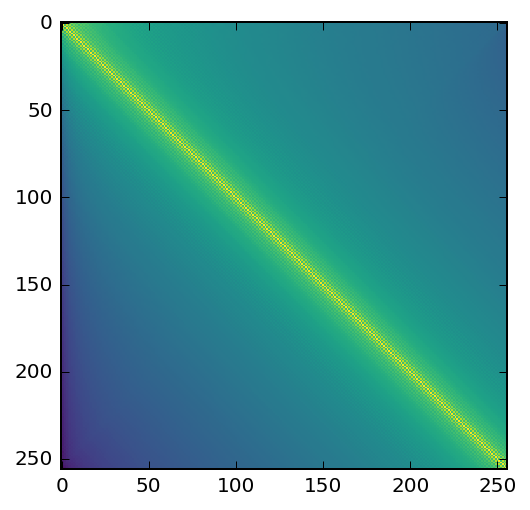

In [116]:
pl.imshow(np.log10(pse.M_l1l2), interpolation='None', cmap=P.CMAP)

/Users/dlenz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


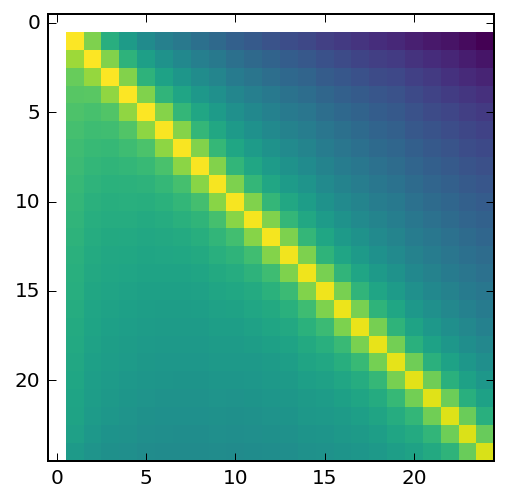

In [115]:
pl.imshow(np.log10(pse.K_b1b2), interpolation='None', cmap=P.CMAP)